Notebook imitant:
    https://towardsdatascience.com/causal-machine-learning-for-econometrics-causal-forests-5ab3aec825a7

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#Read main data to DataFrame
df = pd.read_stata('macoursetal_main.dta')  

In [6]:
# "hogarid_old","cp_old","unique_05", "cpmom_06" seran usats com a index
df_out=df[["a5sscore_i_06","a6smemory_p1_06","a6smemory_p2_06","a7a_delay_06","a7b_delay_06",
        "a7c_delay_06","a7d_delay_06","a9sgrossmotor_06","height_06","weight_06","z_tvip_06","z_social_06",
        "z_language_06","z_finmotor_06","z_memory_06","z_grmotor_06","z_legmotor_06","z_behavior_06","z_height_06",
        "z_weight_06","z_all_06"]]


# Income variables

In [7]:
df1=df[["hogarid_old","cp_old","unique_05","s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05",
        "s1hhsz_15_24_05","s1hhsz_25_64_05","s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05",
        "s3ap23_stime_h_05","s3ap24_htime_h_05","s3ap25_hqtime_h_05","s3atoilet_hh_05","s3awater_access_hh_05",
        "s3aelectric_hh_05","s4p6_vitamina_i_05","s4p7_parasite_i_05","s11ownland_hh_05","cons_food_pc_05","cons_tot_pc_05",
        "tvip_05","height_05","a10whz_05","weight_05","itt_i","itt_all_i","yrsedfath","age_transfer","bweight",
        "s4p7_parasite_i_06","cpmom_06","T","male","TREAT1","TREAT2","TREAT3","TREAT4","ed_mom","MUN1","MUN2","MUN3","MUN4",
        "MUN5","MUN6","com_haz_05","com_waz_05","com_tvip_05","com_control_05","com_vit_05","com_deworm_05","com_notvip",
        "sample06","vitamiron_06",#"weighted_05",
        "propfood_05","prstap_f_05","pranimalprot_f_05","prfruitveg_f_05"]]

In [8]:
df1.rename(columns = {'T':'tr'}, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


###  NaNs

In [9]:
df1.isnull().sum(axis=1).value_counts()

1     1357
11     910
0      631
8      427
2      243
5      212
4      133
3      130
12     129
7      112
9       66
6       59
10      48
55      32
56       7
54       7
14       6
13       2
dtype: int64

In [10]:
#fem una copia del df
def copy_df(df):
   return df.copy()

In [11]:
#eliminem individus amb >delta*100% columnes buides
def drop_ind_missing(df, delta):
    thresh = len(df.columns)*delta
    df.dropna(axis=0, thresh=thresh, inplace=True)
    return df

In [12]:
#eliminem individus amb age transfer<age
def drop_out_missing(df, age=-11):
    nan_rows=df[df.age_transfer<age].index
    df.drop(nan_rows, inplace=True)
    return df

In [13]:
#categorical to ordinal
def ordinal(df, cols):
    enc = OrdinalEncoder()
    enc.fit(df[cols])
    df[cols] = enc.transform(df[cols])
    
    return df

In [14]:
#imputem NaNs

#imputem mitjanes
def mean_imputer(df, cols):
    for col in cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

#imputem el valor més frequent de la columna dintre el hh
def hh_mf_imputer(df,cols):
    index=df.index
    for col in cols:
        col_hh=[df[df.hogarid_old==familia][[col,"age_transfer"]].sort_values(by=['age_transfer'])[col]
                .values for familia in df.hogarid_old]
        for i in range(len(index)):
               if np.isnan(df[col][index[i]]):
                    non_nan_len=np.count_nonzero(~np.isnan(col_hh[i]))
                    if(non_nan_len!=0):
                        vals,counts = np.unique(col_hh[i], return_counts=True)
                        ind = np.argmax(counts)
                        df.loc[index[i],col]=vals[ind]
    return df             
                            
                        

In [15]:
#eliminem outliers

def outlier_removal(df, cols):
    outlier_threshold = []
    for col in cols:
            q3 = np.nanpercentile(df[col], 75)
            q1 = np.nanpercentile(df[col], 25)
            iqr = q3 - q1
            out_low = q1 - 3*iqr
            out_high = q3 + 3*iqr
            outlier_threshold.append([out_low, out_high])
    outliers_indexs=[]
    for col,k in zip(cols,range(len(cols))):
        #outliers_indexs_in_col=[]
        for i in df[col].index:
            if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
                outliers_indexs.append(i)
        #outliers_indexs.append(outliers_indexs_in_col)
    return df.drop(list(set(outliers_indexs)), axis=0)

In [16]:
def normalize(df, cols):
    Nscaler = MinMaxScaler()

    Nscaler.fit(df[cols])
    df[cols] = Nscaler.transform(df[cols])
    
    return df

def standardize(df, cols):
    Sscaler = StandardScaler()

    Sscaler.fit(df[cols])
    df[cols] = Sscaler.transform(df[cols])
    
    return df

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mean_cols=["bweight", "tvip_05", "height_05", "a10whz_05", "weight_05"]
hh_mf_cols=["s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05","s1hhsz_15_24_05","s1hhsz_25_64_05",
            "s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05","s3atoilet_hh_05",
            "s3awater_access_hh_05","s3aelectric_hh_05","s11ownland_hh_05","s4p7_parasite_i_06","ed_mom","vitamiron_06",
           "s4p6_vitamina_i_05", "s4p7_parasite_i_05", "cons_food_pc_05", "yrsedfath", "propfood_05", "prstap_f_05"
            ,  "pranimalprot_f_05",  "prfruitveg_f_05"]

categorical_cols=df1.select_dtypes(exclude=["number","bool_","object_"]).columns
outlier_cols=["pranimalprot_f_05", "bweight", "prfruitveg_f_05"]

normal_cols =["height_05","a10whz_05","weight_05","com_haz_05","com_waz_05"]

Nnormal_cols = ['s1age_head_05', 's3ap23_stime_h_05', 's3ap24_htime_h_05', 's3ap25_hqtime_h_05', 'cons_food_pc_05', 
                'cons_tot_pc_05', 'tvip_05', 'yrsedfath','age_transfer', 'bweight', 'ed_mom', 'com_tvip_05', 'com_control_05']


cleaned_df=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols)
            .pipe(hh_mf_imputer, hh_mf_cols)
            .pipe(mean_imputer, mean_cols+hh_mf_cols)
            .pipe(outlier_removal, outlier_cols)) #outliers
            #.pipe(standardize, normal_cols) #estandaritzacio
            #.pipe(normalize, Nnormal_cols)) #normalitzacio
                         

ValueError: Input contains NaN

In [18]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = ["s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05",
        "s1hhsz_15_24_05","s1hhsz_25_64_05","s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05",
        "s3ap23_stime_h_05","s3ap24_htime_h_05","s3ap25_hqtime_h_05","s3atoilet_hh_05","s3awater_access_hh_05",
        "s3aelectric_hh_05","s4p6_vitamina_i_05","s4p7_parasite_i_05","s11ownland_hh_05","cons_food_pc_05","cons_tot_pc_05",
        "tvip_05","height_05","a10whz_05","weight_05","itt_i","itt_all_i","yrsedfath","age_transfer","bweight",
        "s4p7_parasite_i_06","male","TREAT1","TREAT2","TREAT3","TREAT4","ed_mom","MUN1","MUN2","MUN3","MUN4",
        "MUN5","MUN6","com_haz_05","com_waz_05","com_tvip_05","com_control_05","com_vit_05","com_deworm_05","com_notvip",
        "sample06","vitamiron_06",
        "propfood_05","prstap_f_05","pranimalprot_f_05","prfruitveg_f_05"]

In [21]:
df.drop(df[df_out.iloc[df.index].z_all_06.isna()].index, axis=0, inplace=True)

In [22]:
cleaned_df["z_all_06"]=df_out.iloc[cleaned_df.index].z_all_06

NameError: name 'cleaned_df' is not defined

In [69]:
cp_cols=["hogarid_old","cp_old","unique_05", "cpmom_06"]

In [71]:
cleaned_df.drop(cp_cols, axis=1, inplace=True)

In [80]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

In [100]:
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV

# set parameters for causal forest 
causal_forest1 = CausalForestDML(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )
                      
# fit train data to causal forest model 
causal_forest1.fit(Y, T, X=X, W=W)
# estimate the CATE with the test set 
causal_forest1.const_marginal_ate(X_test)

In [ ]:
causal_forest1_ate

In [88]:
pd.Series(causal_forest.feature_importances_,index=causal_forest.cate_feature_names()).sort_values()

sample06                 0.000000
MUN2                     0.000017
TREAT2                   0.000046
MUN3                     0.000101
TREAT4                   0.000193
s3awater_access_hh_05    0.000562
TREAT1                   0.000667
itt_i                    0.000689
s1hhsz_65plus_05         0.000743
MUN6                     0.001219
MUN1                     0.001269
s3aelectric_hh_05        0.001656
MUN4                     0.001715
s11ownland_hh_05         0.002158
s4p7_parasite_i_06       0.002189
tvip_05                  0.002306
s1hhsz_25_64_05          0.002395
vitamiron_06             0.002478
itt_all_i                0.002628
s1male_head_05           0.002754
s3atoilet_hh_05          0.002855
s3ap5_rooms_h_05         0.003330
MUN5                     0.004598
male                     0.005098
s4p6_vitamina_i_05       0.005810
s4p7_parasite_i_05       0.006341
s1hhsz_undr5_05          0.006604
s1hhsz_5_14_05           0.007135
s3ap25_hqtime_h_05       0.008662
s1hhsize_05   

In [90]:
import shap
from econml.dml import CausalForestDML

# fit causal forest with default parameters 
causal_forest = CausalForestDML()
causal_forest.fit(Y, T, X=X, W=W)

# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X)


'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

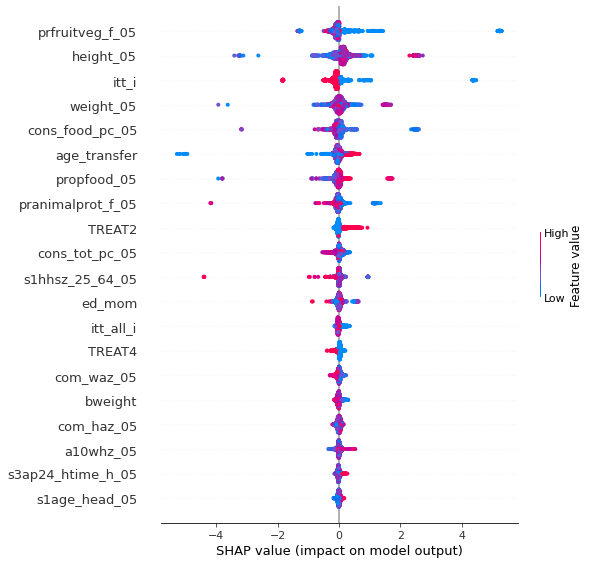

In [99]:

# plot shap values 
shap.summary_plot(shap_values['z_all_06']["tr"])

In [1]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = ["s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05",
        "s1hhsz_15_24_05","s1hhsz_25_64_05","s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05",
        "s3ap23_stime_h_05","s3ap24_htime_h_05","s3ap25_hqtime_h_05","s3atoilet_hh_05","s3awater_access_hh_05",
        "s3aelectric_hh_05","s4p6_vitamina_i_05","s4p7_parasite_i_05","s11ownland_hh_05","cons_food_pc_05","cons_tot_pc_05",
        "tvip_05","height_05","a10whz_05","weight_05","itt_i","itt_all_i","yrsedfath","age_transfer","bweight",
        "s4p7_parasite_i_06","male","ed_mom","MUN1","MUN2","MUN3","MUN4",
        "MUN5","MUN6","sample06","vitamiron_06","propfood_05","prstap_f_05","pranimalprot_f_05","prfruitveg_f_05"]

In [2]:
cleaned_df.drop(cleaned_df[df_out.iloc[cleaned_df.index].z_all_06.isna()].index, axis=0, inplace=True)

NameError: name 'cleaned_df' is not defined